### Video-Based Gaze Tracking tutorial (3/5)
This is a lecture of the Video-Based Gaze Tracking tutorial of the [Bridging the Technological Gap Summer Workshop](https://psychandneuro.duke.edu/opportunity/bridging-technological-gap-summer-workshop), July 31st – August 6th, 2022, German Primate Center, Göttingen, Germany.

More info at [https://github.com/erkil1452/gaze_workshop_public](https://github.com/erkil1452/gaze_workshop_public).

Made by Petr Kellnhofer, 2022.

In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path('.').resolve().absolute().parent))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import cv2
import imageio
import dlib
import nbimporter

# Automatically reload our library.
%reload_ext autoreload
%autoreload 1
from src import gaze_utils as gu
%aimport src

# Import solutions from our previous notebook(s).
from s01_capture import capture_frame, detect_face, crop_image

DATA_PATH = Path('.').resolve().absolute().parent / 'data'
sample_data = gu.WorkshopDataset(DATA_PATH / 'gazecapture' / '00192')

## 3. Neural networks.

In this section we will explain basic neural network structures. We will design a simple neural network that accepts the entire face to predicts a 2D gaze.

### 3.1 Inputs.

As a first step, it is advantegous to resize all input images to the same shape. We have already cropped our face images to squares so now we just make sure they have a fixed size (127x127) pixels.

The original face crop shape: (324, 324, 3).
The resized face crop shape: (127, 127, 3).


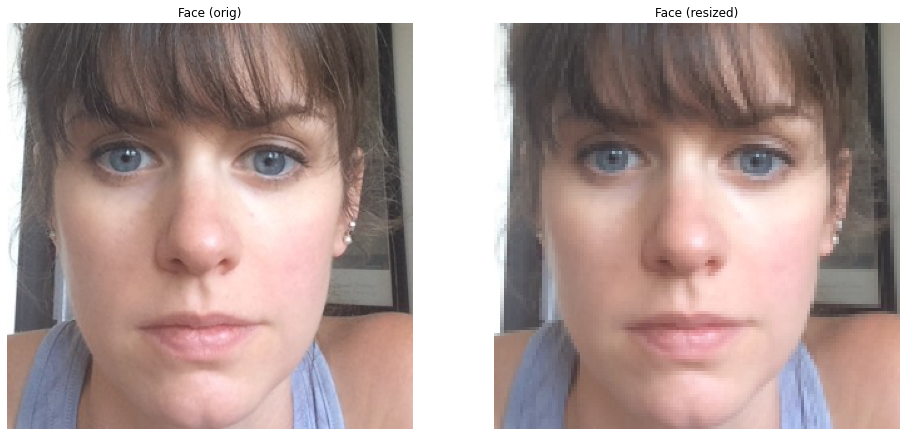

In [2]:
# Get a face image.
frame = sample_data.get_image(0)
face_crop = crop_image(frame, detect_face(frame))
print(f'The original face crop shape: {face_crop.shape}.')

# Resize.
INPUTS_SIZE = (127, 127)
face_crop_in = cv2.resize(face_crop, INPUTS_SIZE, interpolation=cv2.INTER_AREA)
print(f'The resized face crop shape: {face_crop_in.shape}.')
gu.show_images([face_crop, face_crop_in], ['Face (orig)', 'Face (resized)'])

Next, we need to convert the image to a format that the neural network expects. Write a helper method that will do all the processing at once starting from a cropped face image.
1. Resize the image to a given size using `cv2.resize` as above.
2. Rescale the image range from [0, 255] to [-1, 1] to improve numerical staibility of the network.
3. Convert the image to a torch tensor using `torch.from_numpy`.
4. Our face image is originally stored as `H x W x C` array where `C` is the number of channels (3 for our RGB) and `H`, `W` is height and width of the image. Convolutional neural networks typically accept images in shape `C x H x W` where `B` is the number of images (1 for now). Shuffle the dimensions using `tensor.permute(2,0,1)` to convert from `H x W x C` to  `C x H x W`.

In [3]:
def numpy_image_to_tensor(im: np.array, input_size: tuple = (127, 127)) -> torch.Tensor:
    """ Converts a numpy image to network input tensor of a fixed size input_size. """
    # TODO
    raise NotImplementedError()
    # 1. Resize to expected size.
    # 2. Convert to float32 and normalize to [-1,1].
    # 3. Convert to torch.tensor.
    # 4. Reshape from HxWxC to CxHxW
    return im_tensor

Test it:

In [8]:
im_tensor = numpy_image_to_tensor(face_crop, INPUTS_SIZE)
print(f'HxWxC: {face_crop_in.shape}')
print(f'CxHxW: {im_tensor.shape}')
print(f'Original range: [{face_crop_in.min()}, {face_crop_in.max()}]')
print(f'Normalized range: [{im_tensor.min().item()}, {im_tensor.max().item()}]')

HxWxC: (127, 127, 3)
CxHxW: torch.Size([3, 127, 127])
Original range: [41, 255]
Normalized range: [-0.6784313917160034, 1.0]


Finally, we add another dimension `B` for the number of inputs (batch size). Neural networks typically accept multiple inputs at once but in our case we will just use a single image for now. Therefore, `B = 1`:

In [9]:
net_input = im_tensor.unsqueeze(0)
print(f'BxCxHxW: {im_tensor.shape}')

BxCxHxW: torch.Size([3, 127, 127])


### 3.2 Network layers.

Now let's understand what the individual network layers do. 

#### 3.2.1 Convolutional layer
First layer is the convolutional layer. It convolves the input image by a linear filter. Initially, the layer has random weights for a random filter and, hence, the output is also random. Try to run multiple times, you will get different results each time.

First, we will test our gaze network model from Sec. 3 and see what it does for our sample image.

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))
Input shape: torch.Size([1, 3, 127, 127])
Output shape: torch.Size([1, 1, 125, 125])


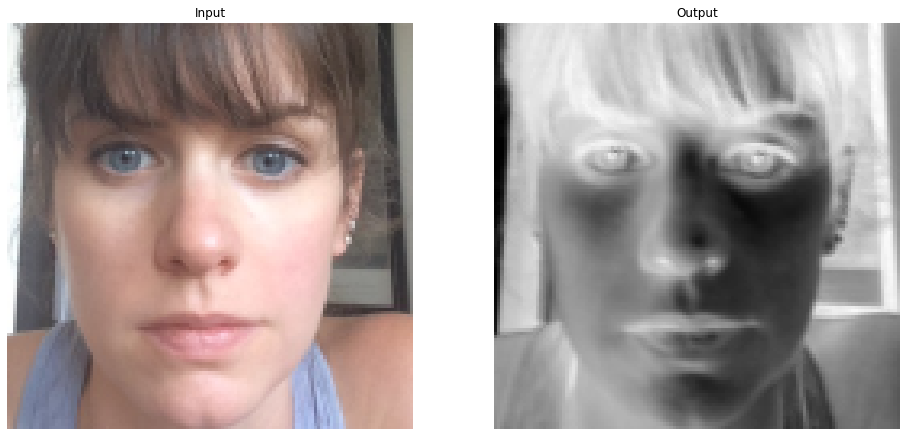

In [10]:
# Create a 3x3 convolution layer (kernel_size=3) that accepts RGB image (3) and produces single channel image (1).
layer = nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=0)
# Print text representation.
print(layer)

print(f'Input shape: {net_input.shape}')
conv_out = layer(net_input)
print(f'Output shape: {conv_out.shape}')

gu.show_images([net_input[0] * 0.5 + 0.5, conv_out[0]], ['Input', 'Output'])

Try to run the cell multiple times. You should get different results every times based on the random weight initialization.

We can manually define the convolution weights to represent e.g. horizontal gradient.

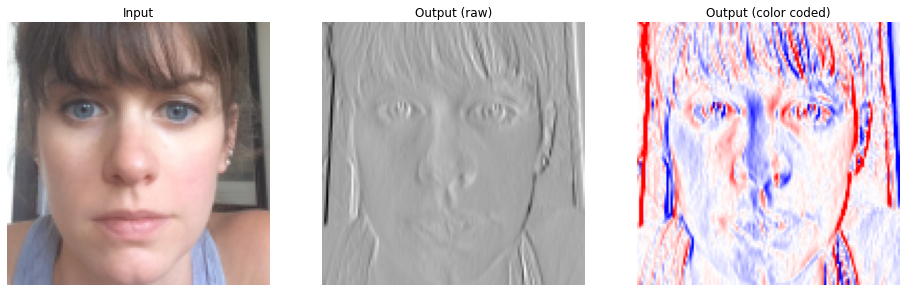

In [11]:
with torch.no_grad():
    layer.weight[:] = 0
    layer.bias[:] = 0
    layer.weight[:,:,:,0] = -1 # Subtract left-most pixels.
    layer.weight[:,:,:,1] = 1  # From the right-most pixels.
conv_out = layer(net_input)

gu.show_images([net_input[0] * 0.5 + 0.5, conv_out[0], gu.colormap_image(-conv_out[0], -2, 2),], ['Input', 'Output (raw)', 'Output (color coded)'])

### 3.2.2 ReLU

The next layer is very simple. ReLU just clamps negative values to zero: `y = max(x, 0)`. However, it is very important for the network capability to learn complex non-linear functions. Without ReLU we would be just stacking (linear) convolutions which are together still equivalent to doing a single linear filtering operation.

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))


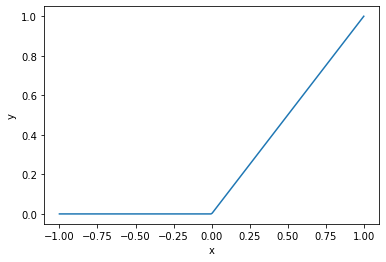

In [12]:
# Create ReLU
relu = nn.ReLU()
print(layer)

# Plot function values.
plt.figure()
x = torch.linspace(-1, 1, 256)
plt.plot(x, relu(x[None])[0])
plt.xlabel('x')
plt.ylabel('y');

If we apply ReLU to the gradient we computed before, the negative edges are removed.

Input shape: torch.Size([1, 1, 125, 125])
Output shape: torch.Size([1, 1, 125, 125])


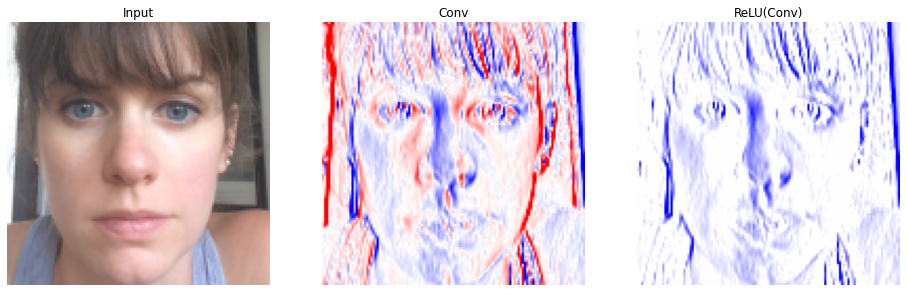

In [13]:
print(f'Input shape: {conv_out.shape}')
relu_out = relu(conv_out)
print(f'Output shape: {relu_out.shape}')

gu.show_images([
    net_input[0] * 0.5 + 0.5, 
    gu.colormap_image(-conv_out[0], -2, 2),
    gu.colormap_image(-relu_out[0], -2, 2)
    ], ['Input', 'Conv', 'ReLU(Conv)'])

### 3.2.3 Sigmoid

Sigmoid is another example of nonlinearity. It squeezes any real number into `[0,1]` which is useful for bounded outputs.

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))


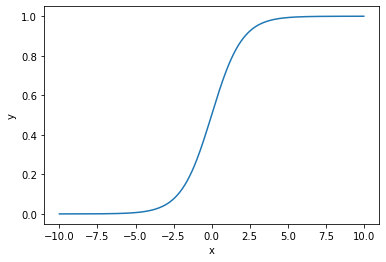

In [14]:
sigmoid = nn.Sigmoid()
print(layer)

plt.figure()
x = torch.linspace(-10, 10, 256)
plt.plot(x, sigmoid(x[None])[0])
plt.xlabel('x')
plt.ylabel('y');

### 3.2.4 Pooling

Finally, we use pooling to reduce resolution of the image which saves computations and allows to capture more global features. The pooling below takes max value from 2x2 image neighborhood and reduced the image size by half. It preserves the highest values in the `2x2` neighborhood. The idea is that it selects the region where the network activates the most, which should be the region with interesting information.

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Input shape: torch.Size([1, 3, 127, 127])
Output shape: torch.Size([1, 3, 63, 63])


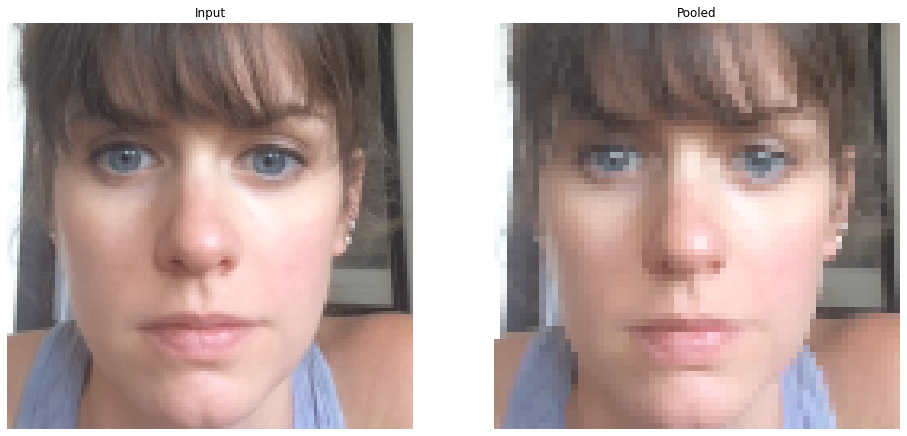

In [15]:
pooler = nn.MaxPool2d(kernel_size=2, stride=2)
print(pooler)

print(f'Input shape: {net_input.shape}')
pooler_out = pooler(net_input)
print(f'Output shape: {pooler_out.shape}')

gu.show_images([
    net_input[0] * 0.5 + 0.5, 
    pooler_out[0] * 0.5 + 0.5,
    ], ['Input', 'Pooled'])

## 3.3 Network architecture

If we combine these layers, we can get a simple convolutional neural network.

In [16]:
conv_model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),          
)

print(conv_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
)


Initially, the network produces a low-resolution field of random features. We have not trained it to do anything more useful yet.

Input shape: torch.Size([1, 3, 127, 127])
Output shape: torch.Size([1, 64, 12, 12])


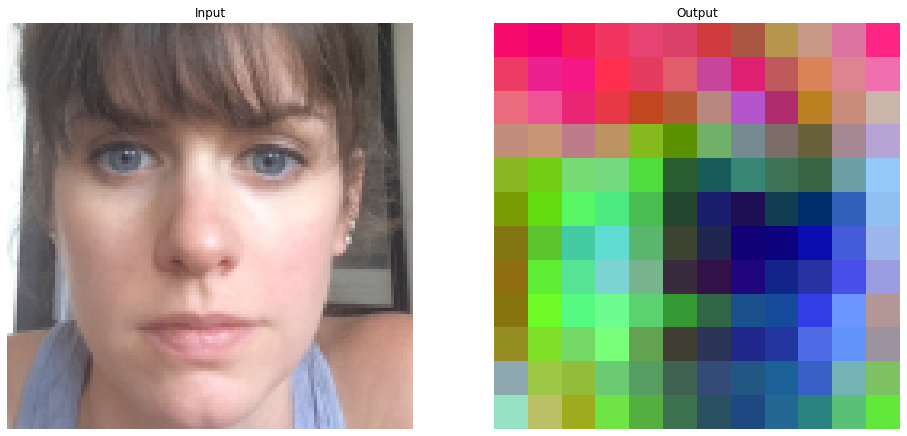

In [17]:
print(f'Input shape: {net_input.shape}')
net_output = conv_model(net_input)
print(f'Output shape: {net_output.shape}')

gu.show_images([
    net_input[0] * 0.5 + 0.5, 
    net_output[0],
    ], ['Input', 'Output'])

We can use these features as input to the gaze prediction module. This is just a multi-layer perceptor (MLP) with two fully connected (linear) layers that transforms the features averaged from the CNN output into a 2D vector - our XY 2D gaze label.

In [18]:
class SimpleGazePredictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 64, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),            
        )

        self.fc = nn.Sequential(
            nn.Linear(6*6*64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
            )

    def forward(self, faces, *args, **kwargs):
        x = self.conv(faces)
        x = x.view(x.size(0), -1)
        x = self.fc(x)        
        return x

model = SimpleGazePredictor()

print(f'Input shape: {net_input.shape}')
net_output = model(net_input)
print(f'Output shape: {net_output.shape}')

Input shape: torch.Size([1, 3, 127, 127])
Output shape: torch.Size([1, 2])


We can always print out network to see what is inside:

In [19]:
print(model)

SimpleGazePredictor(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


Let's test the model:

The predicted gaze is tensor([0.0009, 0.0021], grad_fn=<SelectBackward0>)


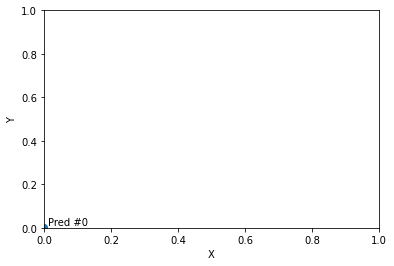

In [20]:
# Execute the model.
net_output = model(net_input)

# Print outputs.
print(f'The predicted gaze is {net_output[0]}')
gu.plot_gaze([net_output], ['Pred'])

The prediction is random but we will learn how to improve this in the next section.